<a href="https://colab.research.google.com/github/pleunipennings/CSC508_ML_Biomedicine_Class/blob/main/Module7/Module_7b_Making_a_graph_for_models_comparison_Antibiotic_resistance_CSC508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Welcome to the module 7b coding part: Making a graph for Models comparison!**

*This notebook was created at San Francisco State University (SFSU) for the Promoting INclusivity and Computing (PINC) and gSTAR programs by Dr. Pleuni Pennings (SFSU biology professor), Lucy Moctezuma Tan (California State University, East Bay CSUEB master student) and Lorena Benitez-Rivera (SFSU master student). All members of the COde to understand Drug resistance Evolution (CODE) lab in 2023.*

The code is based on a project by Faye Orcales, Jameel Ali, Meris Johnson-Hagler, Kristiene Recto, Lucy Moctezuma Tan (all CODE lab members at SFSU), and in turn inspired by work by Danesh Moradigaravand and coauthors [Moradivaravand et al.](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006258)

#OBJECTIVE OF THIS NOTEBOOK:

**Recreating graphs of Accuracies and Recall**

In this notebook we are going to create a graph that will let us compare the performance for all the three models used in notebooks 6b-7a:

1.   **Gradient-Boosted Trees**
2.   **Random Forest**
3.   **Logistic Regression** 

We will also be able to check what combinations were best for each drug. Below is an example of the graph we want to achieve with this code:

![main graph](https://drive.google.com/uc?export=view&id=1vXpJd53KWg2CjJUeAAfFk0iQdWzoKLF7)




## **Step 1) Importing packages needed for visualization**

**NOTE:** Please allow access to your google drive when prompted, this will let you create and store the files in your drive to be accessed.

In [ ]:
# Data Wrangling Imports
import pandas as pd
import numpy as np

# Data visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

# File Manipulation Imports
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **Step 2) Loading each models scores and join them into a single dictionary**

In [ ]:
# Loading all models metrics and joint them in a dictionary:
filepath = "/content/drive/MyDrive/EColi_ML_CSV_files/"

Model_Scores = {}

# Loading all data frames
LG_metrics = pd.read_csv(filepath+"LG_metrics_df.csv")
RF_metrics = pd.read_csv(filepath+"RF_metrics_df.csv")
GB_metrics = pd.read_csv(filepath+"GB_metrics_df.csv")

# Adding all dataframes to dictionary
Model_Scores["Logistic_Regression"] = LG_metrics
Model_Scores["Random_Forest"] = RF_metrics
Model_Scores["Gradient_Boosted_Trees"] = GB_metrics


## **Step 3) Selecting only the bestscores for each drug from each model**

In [ ]:
# Extracting list of combos from dictionary created
combo_list = list(Model_Scores['Gradient_Boosted_Trees']["Drug_combo"].str.split("_", expand= True)[1].unique())
combo_list 

['G', 'S', 'GY', 'GS', 'SY', 'GYS']

In [ ]:
# Extracting list of drugs from dictionary created
drug_list = list(Model_Scores['Gradient_Boosted_Trees']["Drug_combo"].str[:3].unique()) 
drug_list 

['CTZ',
 'CTX',
 'AMP',
 'AMX',
 'AMC',
 'TZP',
 'CXM',
 'CET',
 'GEN',
 'TBM',
 'TMP',
 'CIP']

**a) Creating a function to scan the best metrics for each drug**

In [ ]:
# creating function that will take the best scores from each model
def Best_metrics(model,df):
  print("Selecting Best Scores for model: ",model)
  bestcores_dic = {}
  for drug in drug_list:
    data = df.loc[df["Drug_combo"].str.startswith(drug)]
    max_acc = max(data["Accuracy"])
    drug_combo = data["Drug_combo"][data["Accuracy"] == max_acc].unique()[0]
    S_rec = float(data[data["Drug_combo"] == drug_combo]["S_recall"])
    R_rec = float(data[data["Drug_combo"] == drug_combo]["R_recall"])
    bestcores_dic[drug_combo] = [max_acc, R_rec, S_rec]
  bestscores_df = pd.DataFrame.from_dict(bestcores_dic, orient ='index',columns=["Accuracy", "R_recall", "S_recall"]).reset_index()
  bestscores_df = bestscores_df.rename(columns = {'index':'Drug_combo'})
  return bestscores_df

**b) Using the function for the results from our Logistic Regression model.**

In [ ]:
# Implementation of function Best_metrics() example with Logistic Regression scores
LG_best_metrics = Best_metrics("Logistic_Regression", Model_Scores["Logistic_Regression"])
LG_best_metrics

Selecting Best Scores for model:  Logistic_Regression


,Drug_combo,Accuracy,R_recall,S_recall
0,CTZ_G,0.935837,0.662921,0.980000
1,CTX_GY,0.969055,0.868852,0.993902
2,AMP_G,0.823741,0.913043,0.563380
3,AMX_GY,0.875691,0.879464,0.869565
4,AMC_GY,0.780180,0.582353,0.867532
5,TZP_G,0.931408,0.090909,0.984645
6,CXM_GY,0.876369,0.659218,0.960870
7,CET_G,0.852518,0.817391,0.877301
8,GEN_G,0.938967,0.696970,0.983333
9,TBM_G,0.848921,0.674157,0.931217


## **Step 4) Converting combo strings into separate columns**

Combo strings for **years of isolation (Y), gene absence/presence (G) and the population structure (S)** data (features).

The function below will allow us to plot the squares below our bar graphs so that we can tell which feature combinations were used.

In [ ]:
# Creating a function that takes the combo strings from Drug_combo column and turns them into separate columns
def make_GYS(bestscores_df):
  # Create 3 new columns one for each type of features (Year of isolation, gene absence or presence, and population structure)
  bestscores_df["G"] = " "
  bestscores_df["Y"] = " "
  bestscores_df["S"] = " "
  
  # Read the combo part of Drug_combo
  split_c = bestscores_df["Drug_combo"].str.split("_", expand=True)
  i=0
  while i < len(split_c[1]):
    split_each_c = [x for x in split_c[1][i]]
    for g in split_each_c:
      if "G" in split_each_c:
        bestscores_df.at[i,"G"] = 1
      else:
        bestscores_df.at[i,"G"] = 0
    for y in split_each_c:
      if "Y" in split_each_c:
        bestscores_df.at[i,"Y"] = 1
      else:
        bestscores_df.at[i,"Y"] = 0
    for s in split_each_c:
      if "S" in split_each_c:
        bestscores_df.at[i,"S"] = 1
      else:
        bestscores_df.at[i,"S"] = 0
    i += 1
  bestscores_df["Drug_combo"] = bestscores_df["Drug_combo"].map(lambda x: x.rstrip('_GYS'))
  bestscores_df.rename(columns={"Drug_combo": "Drug"}, inplace = True) 

  return bestscores_df

Below is an implementation of the function we just created, using our Logistic Regression results.

In [ ]:
# Implementing function make_GYS()
GYS_LG_best_metrics = make_GYS(LG_best_metrics)
GYS_LG_best_metrics

,Drug,Accuracy,R_recall,S_recall,G,Y,S
0,CTZ,0.935837,0.662921,0.980000,1,0,0
1,CTX,0.969055,0.868852,0.993902,1,1,0
2,AMP,0.823741,0.913043,0.563380,1,0,0
3,AMX,0.875691,0.879464,0.869565,1,1,0
4,AMC,0.780180,0.582353,0.867532,1,1,0
5,TZP,0.931408,0.090909,0.984645,1,0,0
6,CXM,0.876369,0.659218,0.960870,1,1,0
7,CET,0.852518,0.817391,0.877301,1,0,0
8,GEN,0.938967,0.696970,0.983333,1,0,0
9,TBM,0.848921,0.674157,0.931217,1,0,0


## **Step 5) Extracting best metrics and coding for GYS into columns for all models**

We have 3 models so the code below will implement the function we created in the previous step for all 3 models results.

In [ ]:
# Getting the best metrics for all the models
Best_metrics_models = {}
for model, df in Model_Scores.items():
  # select the best scores obtained from each model
  Model_best_metrics = Best_metrics(model, df) 

  # Code GYS data in 0 "for absence" and 1 "for presence" into 3 columns
  GYS_coded_best = make_GYS(Model_best_metrics)
  print(GYS_coded_best)

  # Save new dataframe in a dictionary with best metrics selected
  Best_metrics_models[model] = GYS_coded_best


Selecting Best Scores for model:  Logistic_Regression
   Drug  Accuracy  R_recall  S_recall  G  Y  S
0   CTZ  0.935837  0.662921  0.980000  1  0  0
1   CTX  0.969055  0.868852  0.993902  1  1  0
2   AMP  0.823741  0.913043  0.563380  1  0  0
3   AMX  0.875691  0.879464  0.869565  1  1  0
4   AMC  0.780180  0.582353  0.867532  1  1  0
5   TZP  0.931408  0.090909  0.984645  1  0  0
6   CXM  0.876369  0.659218  0.960870  1  1  0
7   CET  0.852518  0.817391  0.877301  1  0  0
8   GEN  0.938967  0.696970  0.983333  1  0  0
9   TBM  0.848921  0.674157  0.931217  1  0  0
10  TMP  0.870504  0.857143  0.880503  1  0  0
11  CIP  0.949922  0.842466  0.981744  1  0  0
Selecting Best Scores for model:  Random_Forest
   Drug  Accuracy  R_recall  S_recall  G  Y  S
0   CTZ  0.917058  0.505618  0.983636  1  0  1
1   CTX  0.960912  0.852459  0.987805  1  0  0
2   AMP  0.816547  0.937198  0.464789  1  1  0
3   AMX  0.784530  0.879464  0.630435  1  1  0
4   AMC  0.778378  0.464706  0.916883  1  0  0
5   T

## **Step 6) Creating a function to plots bar charts for each metric**
The function we create below will allow us to graph the bar charts for each of our antibiotic drugs.

In [ ]:
def barplot(metric_col, subplot_axis, label_show = True):
  for model, df in Best_metrics_models.items():
    X_axis = np.arange(len(drug_list))
    X_labels = drug_list

    Y_axis = np.arange(0,1.2,0.2)

    subplot_axis.set_ylabel(metric_col, fontsize = 14)
    subplot_axis.set_ylim(bottom=0, top=1)

    subplot_axis.set_xticklabels(X_labels, fontsize = 15)
    subplot_axis.set_xticks(X_axis)
    subplot_axis.margins(x=0)

    if label_show == False:
      subplot_axis.tick_params(left = True, right = False , labelleft = True , labelbottom = False, bottom = True)

    if model == "Logistic_Regression":
      X_axis = X_axis - 0.2
      color = "plum"
      label = "LG"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.25, align = 'center', color = color, label = label, edgecolor="gray")
    elif model == "Random_Forest":
      X_axis = X_axis + 0.075
      color = "cadetblue"
      label = "RF"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.25, align = 'center', color = color, label = label, edgecolor="gray")
    elif model == "Gradient_Boosted_Trees":
      X_axis = X_axis + 0.35
      color = "goldenrod"
      label = "GB"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.25, align = 'center', color = color, label = label, edgecolor="gray")
  return
       

Below we implement this function for the best results obtained in our Logistic Regression Model. In this case we will be plotting the "Accuracy"

<ipython-input-112-d9497b1d36e3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot_axis.set_xticklabels(X_labels, fontsize = 15)


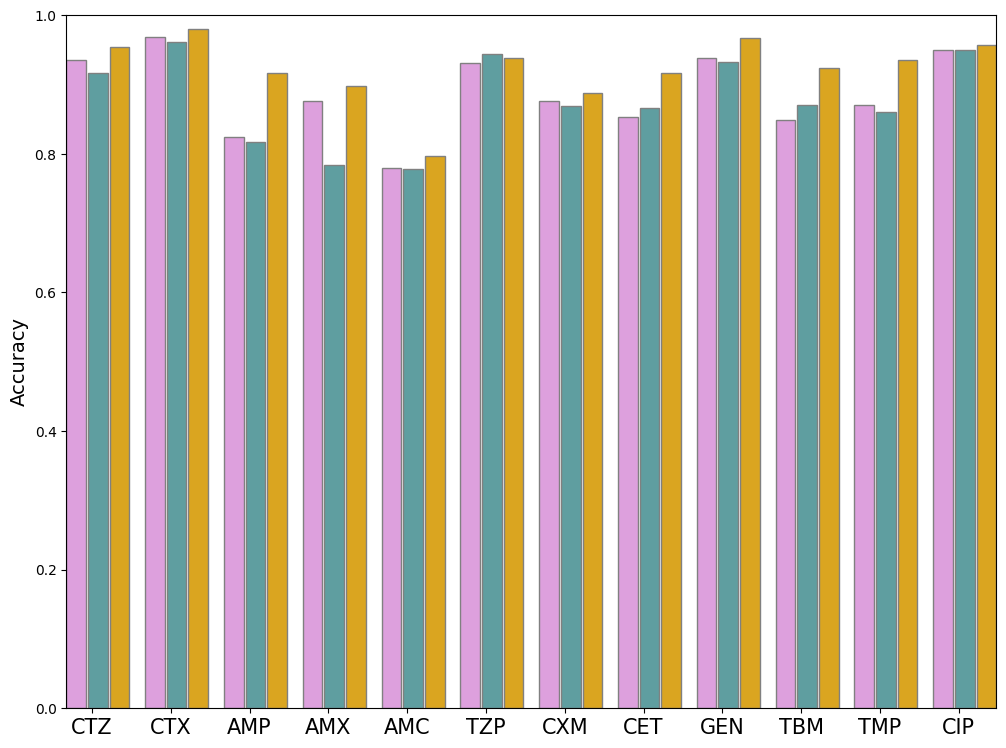

In [ ]:
# implementing function barplot() for one metric "Accuracy"
figure, subs = plt.subplots(1, 1,figsize = (12,9))
acc_plot = barplot("Accuracy",subs,label_show=True)

## **Task 1**:
- Create bar charts using the function above for the best Resistance (R) recall scores.  

In [ ]:
# Input your code for task 1 in this cell!

## **Step 7) Creating a function to plot GYS grids for each drug**
The function below will let us introduce the graphics below each drug, to show us what is the best combination of features.

In [ ]:
# function that creates a graph for each of the drugs
def GYS_gridplot(drug,subplot_axis, label_show = True, title_pos = -0.2):
  # Create 3 new lists one for each type of features (Year, Population structure and Gene presence)
  Y_list = [] # storing whether it used or not year data
  S_list = [] # storing whether it used or not population structure data
  G_list = [] # storing whether it used or not accessory gene data
  
  # Fill up corresponding lists from drug results from each model
  for model, df in Best_metrics_models.items():
    for drug_name in df["Drug"]:
      if drug_name == drug:
        Y_list.append(int(df["Y"][df["Drug"]==drug]))
        S_list.append(int(df["S"][df["Drug"]==drug]))
        G_list.append(int(df["G"][df["Drug"]==drug]))

  Drug_GYS_list = [Y_list, S_list, G_list]     
  
  plt.yticks(np.arange(3), ["Year", "Structure", "Accessory Genes"])
  if label_show == False:
      subplot_axis.tick_params(left = False, labelleft = False)

  orig_map = plt.cm.get_cmap('gray')
  reversed_map = orig_map.reversed()
  subplot_axis.imshow(Drug_GYS_list, cmap = reversed_map)

  subplot_axis.axvline(x=0.5)
  subplot_axis.axvline(x=1.5)
  subplot_axis.axvline(x=2.5)
  subplot_axis.axhline(y=0.5)
  subplot_axis.axhline(y=1.5)
  subplot_axis.set_title(drug, fontsize= 15, y=title_pos) 
  subplot_axis.tick_params(
    axis = 'x',
    which = 'both',
    bottom = False,
    top = False,
    labelbottom = False)
  return [Y_list, S_list, G_list]

The example implementation below shows us the best results obtained from the drug "CTZ" for each of the 3 models. In this case the order would be: **Logistic Regression, Random Forest and Gradient-Boosted Trees**. 

<ipython-input-114-ad239a960cb7>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map = plt.cm.get_cmap('gray')


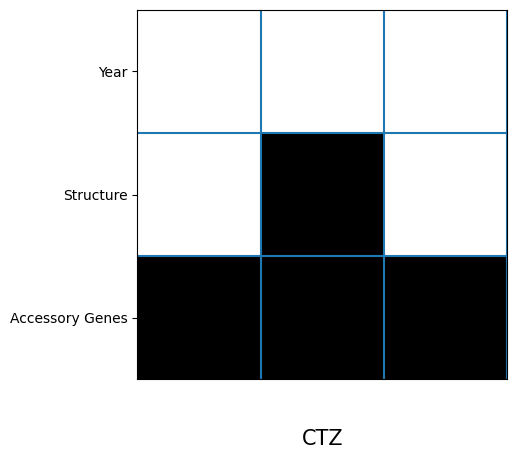

In [ ]:
# implementing function GYS_gridplot() for one drug "CTZ"
figure, subs = plt.subplots()
CTZ_gridplot = GYS_gridplot("CTZ",subs, label_show=True)

## **Step 8) Create the final composite graph (Bargraphs + GYS gridplots)**

Below we create our composite plot (bar charts for each measurement + gridplots) for each of the drugs.

<ipython-input-112-d9497b1d36e3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot_axis.set_xticklabels(X_labels, fontsize = 15)
<ipython-input-114-ad239a960cb7>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map = plt.cm.get_cmap('gray')


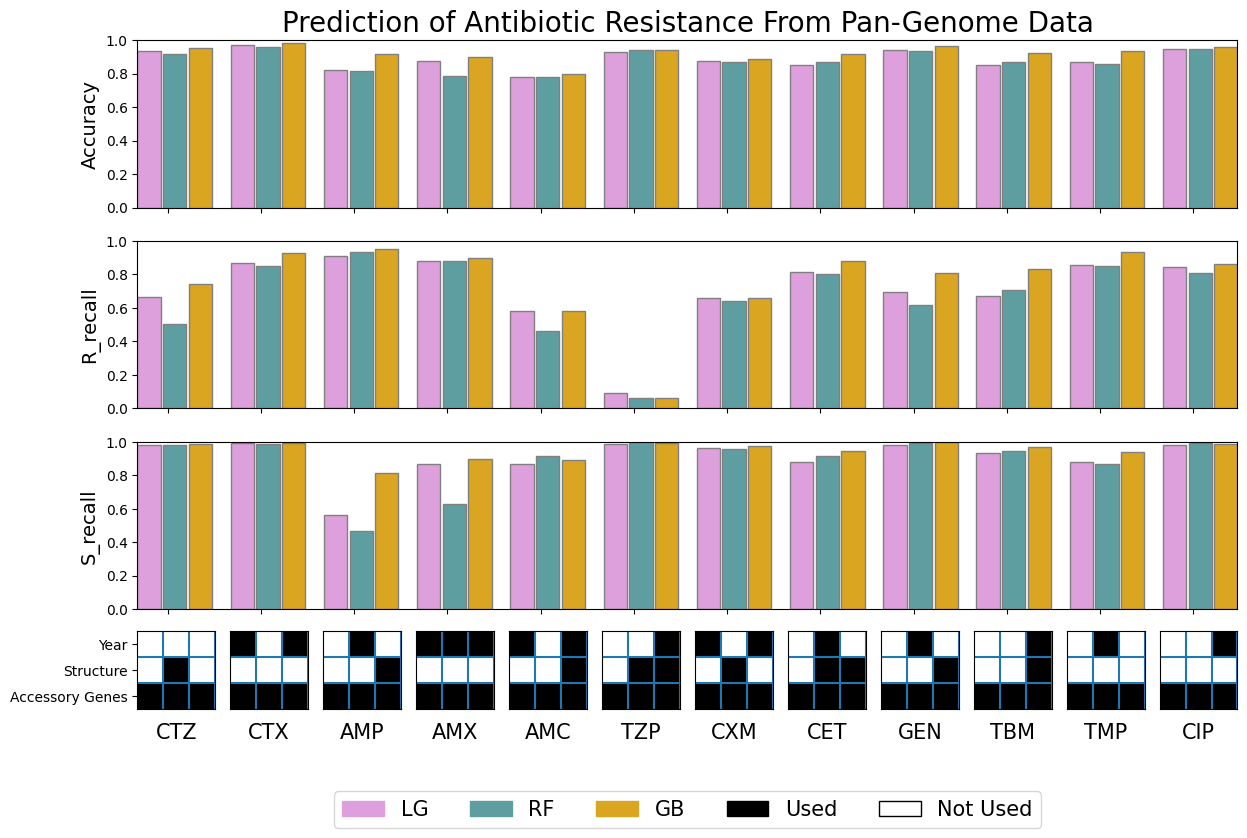

In [ ]:
# Code to create bargraphs

fig = plt.figure(figsize = (20,15), constrained_layout=False)

gs1 = fig.add_gridspec(nrows=4, ncols=12, left=0.05, right=0.6, wspace=0.07)
# Accuracy barcharts for all models
acc_axis = fig.add_subplot(gs1[0, :])
acc_axis.set_title('Prediction of Antibiotic Resistance From Pan-Genome Data', fontsize = 20)
acc_plot = barplot("Accuracy",acc_axis, label_show = False)

# R_recall barcharts for all models
R_rec_axis = fig.add_subplot(gs1[1, :])
R_rec_plot = barplot('R_recall',R_rec_axis, label_show = False)

# S_recall barcharts for all models
S_rec_axis = fig.add_subplot(gs1[2, :])
S_rec_plot = barplot('S_recall',S_rec_axis, label_show = False)

# GYS gridplot charts for each drug
gs2 = fig.add_gridspec(nrows=1, ncols=12, top=0.50,bottom=0,left=0.05, right=0.6, wspace=0.2)
i=0
while (i< len(drug_list)):
  for drug in drug_list:
    if i == 0:
      Drug_grid = fig.add_subplot(gs2[-1, i])
      drug_GYS = GYS_gridplot(drug, Drug_grid, label_show=True, title_pos=-0.5)
      i+=1
    else:
      Drug_grid = fig.add_subplot(gs2[-1, i])
      drug_GYS = GYS_gridplot(drug, Drug_grid, label_show=False, title_pos=-0.5)
      i+=1

legend_elements = [Patch(facecolor='plum', edgecolor='plum', label='LG'),
                   Patch(facecolor='cadetblue', edgecolor='cadetblue', label='RF'),
                   Patch(facecolor='goldenrod', edgecolor='goldenrod', label='GB'),
                   Patch(facecolor='black', edgecolor="black", label='Used'),
                   Patch(facecolor='white', edgecolor="black",label='Not Used')]

plt.legend(handles=legend_elements,loc = 'lower center', bbox_to_anchor=(-6.1, -1), prop ={'size': 15}, borderaxespad=-2, ncol = len(legend_elements))



## **Task 2**:

- Look at the results from our final graph, do you think there might be ways to improve our results? 

- Consider some of the following: would you use different models? Different hyperparameters? Collect more data? Use different parts of the data? 

**Task 2 answer:**

# 🙂 Congratulations, you are done with this module! Now you know how to check if a model performs better for a specific dataset you need to work on for your projects.